In [2]:
import numpy as np
import emlddmm
import torch
from torch.nn.functional import grid_sample
from matplotlib import pyplot as plt
from scipy.interpolate import griddata
# from mayavi import mlab
# mlab.init_notebook()

In [3]:
def interp(x,I,phii,**kwargs):
    '''
    Interpolate a 3D image with specified regular voxel locations at specified sample points.
    
    Interpolate the 3D image I, with regular grid positions stored in x (1d arrays),
    at the positions stored in phii (3D arrays with first channel storing component)
    
    Parameters
    ----------
    x : list of numpy arrays
        x[i] is a numpy array storing the pixel locations of imaging data along the i-th axis.
        Note that this MUST be regularly spaced, only the first and last values are queried.
    I : array
        Numpy array or torch tensor storing 3D imaging data.  I is a 4D array with 
        channels along the first axis and spatial dimensions along the last 3 
    phii : array
        Numpy array or torch tensor storing positions of the sample points. phii is a 4D array
        with components along the first axis (e.g. x0,x1,x1) and spatial dimensions 
        along the last 3.
    kwargs : dict
        keword arguments to be passed to the grid sample function. For example
        to specify interpolation type like nearest.  See pytorch grid_sample documentation.
    
    Returns
    -------
    out : torch tensor
        4D array storing a 3D image with channels stored along the first axis. 
        This is the input image resampled at the points stored in phii.
    
    type(qdot_)
    '''
    # first we have to normalize phii to the range -1,1    
    I = torch.as_tensor(I)
    phii = torch.as_tensor(phii)
    phii = torch.clone(phii)
    for i in range(2):
        phii[i] -= x[i][0]
        phii[i] /= x[i][-1] - x[i][0]
    # note the above maps to 0,1
    phii *= 2.0
    # to 0 2
    phii -= 1.0
    # done
        
    if 'padding_mode' not in kwargs:
        kwargs['padding_mode'] = 'border' # note that default is zero
    out = grid_sample(I[None],phii.flip(0).permute((1,2,0))[None],align_corners=True,**kwargs)
    # note align corners true means square voxels with points at their centers
    # post processing, get rid of batch dimension
    out = out[0]
    return out


# define objective function
def energy(q, I, sigma):
#     qdot = torch.gradient(q,dim=1)[0]
    qdot = q[:,1:] - q[:,:-1]
    # interpolate image at q points
    xI = [torch.arange(x, dtype=torch.double) for x in I.shape]
    q_ = q[:,:-1] + qdot/2
#     q_ = q + qdot/2
    I_q = interp(xI,I[None],q_[:,None])
    E = 0.5 * (torch.sum(qdot**2) + (1/sigma**2)*torch.sum(-I_q.squeeze()*torch.sqrt(torch.sum(qdot**2,0))))

    return E

In [4]:
# load FA
FA = np.load('outputs/amyg_dti_FA.npy')
print(' FA shape: ', FA.shape,'\n',
      'FA dtype: ', FA.dtype,'\n',
      'FA range: ', np.min(FA), np.max(FA))

 FA shape:  (293, 216, 270) 
 FA dtype:  float64 
 FA range:  0.0 1.0


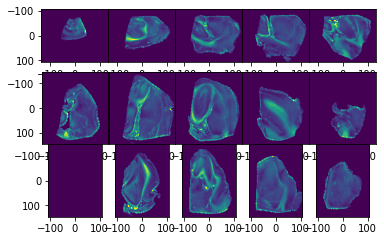

In [4]:
# visualize FA
fig = emlddmm.draw(FA[None])

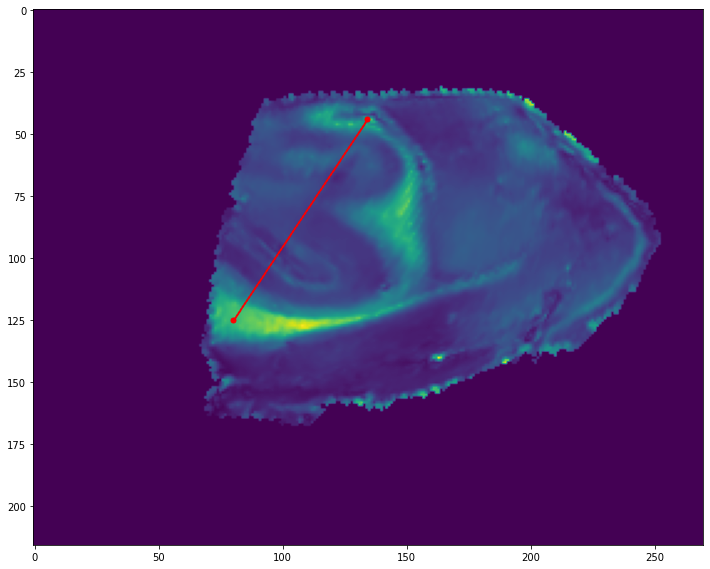

In [5]:
fig = plt.figure(figsize=(12,12))
im = plt.imshow(FA[100])

plt.scatter(x=(80,134),y=(125,44), c='r', s=25)

col = torch.linspace(80,134,1000, dtype=torch.double)
row = torch.linspace(125,44,1000, dtype=torch.double)
plt.scatter(x=col.detach(),y=row.detach(), c='r',s=0.1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,12))
im = plt.imshow(FA[100])

plt.scatter(x=(0,FA.shape[2]-1),y=(100,100), c='r', s=25)

# col2 = torch.linspace(0,FA.shape[2]-1,FA.shape[2], dtype=torch.double)
# row2 = torch.linspace(100,100,FA.shape[2], dtype=torch.double)
col2 = torch.linspace(0,FA.shape[2]-1,300, dtype=torch.double)
row2 = torch.linspace(100,100,300, dtype=torch.double)
plt.scatter(x=col2.detach(),y=row2.detach(), c='r',s=0.1)
plt.show()

In [ ]:
fig = plt.figure(figsize=(12,12))
im = plt.imshow(FA[100])

plt.scatter(x=(100,100),y=(0,FA.shape[1]-1), c='r', s=25)

col3 = torch.linspace(100,100,FA.shape[1], dtype=torch.double)
row3 = torch.linspace(0,FA.shape[1]-1,FA.shape[1], dtype=torch.double)
plt.scatter(x=col3.detach(),y=row3.detach(), c='r',s=0.1)
plt.show()

In [ ]:
q = torch.stack((row,col))
q.requires_grad = True
q2 = torch.stack((row2,col2))
q3 = torch.stack((row3,col3))
I = torch.tensor(FA[100])

In [ ]:
qdot = torch.zeros_like(q[:,:-1])
for i in range(qdot.shape[1]-1):
    qdot[:,i] = torch.stack(((q[0][i+1]-q[0][i]),(q[1][i+1]-q[1][i-1])))
# qdot[:,0] = torch.stack(((q[0][1]-q[0][0]),(q[1][1]-q[1][0])))
# qdot[:,-1] = torch.stack(((q[0][-1]-q[0][-2]),(q[1][-1]-q[1][-2])))

qdot_ = torch.gradient(q,dim=1)[0]

In [ ]:
xI = [torch.arange(x, dtype=torch.double) for x in I.shape]
XI = torch.stack(torch.meshgrid(xI[:2], indexing='ij'))
I_q = interp(xI,I[None],q[:,None])
I_id = interp(xI,I[None],XI)
print(torch.allclose(I_id,I))

In [ ]:
I_q2 = interp(xI,I[None],q2[:,None])
I_q3 = interp(xI,I[None],q3[:,None])
print(np.allclose(I[:,100],I_q3))

In [ ]:
plt.plot(I_q.squeeze().detach())

In [ ]:
plt.plot(I[100].detach())

In [ ]:
plt.plot(I_q2.squeeze())

In [22]:
from time import process_time

col = torch.linspace(80,134,500, dtype=torch.double)
row = torch.linspace(125,44,500, dtype=torch.double)
q = torch.stack((row,col))
q.requires_grad = True
I = torch.tensor(FA[100])

niter = 500000
sigma = 1
eps = 1e-1 * sigma**2
Esave = []
start = process_time()
for i in range(niter):
    E = energy(q,I,sigma)
    E.backward()
    with torch.no_grad():
        q[:,1:-1] -= q.grad[:,1:-1]*eps
        q.grad.zero_()
    Esave.append(E.item())
stop = process_time()

In [9]:
stop - start

47.382075709999995

In [13]:
stop - start

2217.431340982

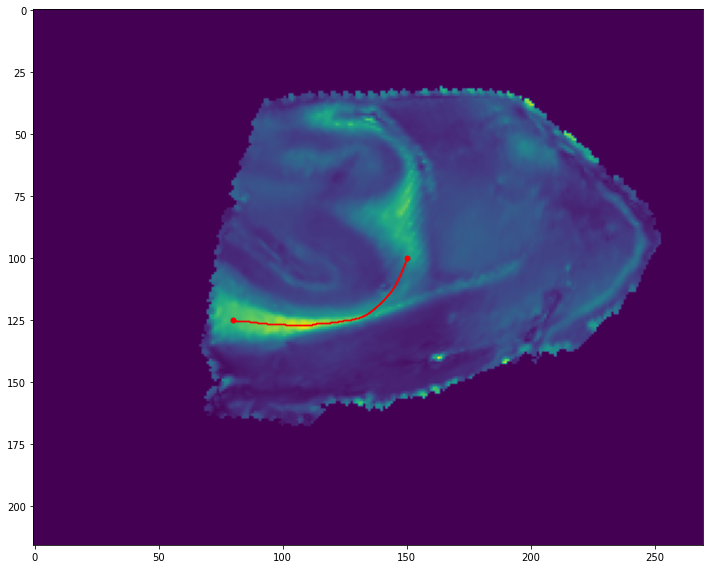

In [9]:
fig = plt.figure(figsize=(12,12))
im = plt.imshow(I)
plt.scatter(x=(80,150),y=(125,100), c='r', s=25)
plt.scatter(x=q[1].detach(),y=q[0].detach(), c='r',s=0.1)
# plt.plot(q[1].detach(),q[0].detach(), c='r')
plt.show()

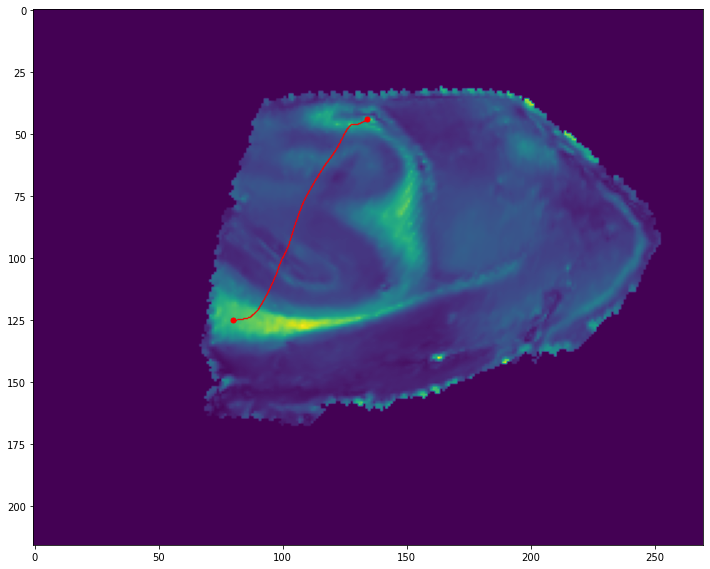

In [23]:
fig = plt.figure(figsize=(12,12))
im = plt.imshow(I)
plt.scatter(x=(80,134),y=(125,44), c='r', s=25)
plt.scatter(x=q[1].detach(),y=q[0].detach(), c='r',s=0.1)
# plt.plot(q[1].detach(),q[0].detach(), c='r')
plt.show()

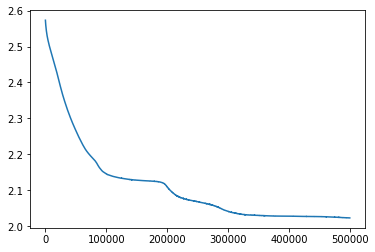

In [24]:
plt.plot(Esave)

In [ ]:
np.save('FA_path', q.detach().numpy())

In [ ]:
import h5py

fname = '/home/brysongray/data/m1229/m1229_other_data/1229_data_for_bryson.mat'

im  = h5py.File(fname, 'r')

In [ ]:
im.keys()

In [ ]:
ADA = im['ADA']

In [ ]:
ADA.shape

In [ ]:
AJiJ = im['AJiJ']

In [ ]:
AJiJ.shape